In [1]:
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import numpy as np

In [2]:
import os
os.environ['KMP_DUPLICATE_OK'] = "TRUE"

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype(float) / 255 #keras: width, height, channel (그림 한장, color면 RGB 3장), alpha (투명도) -- torch: channel, width, height
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype(float) / 255 #Conv2D가 width, height, channel 받아서
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [4]:
model = models.Sequential()
model.add(layers.Conv2D(32, kernel_size=(3,3), input_shape=(28, 28, 1), activation='relu')) #출력 채널 개수, 튜플로 3,3 or 스칼라 3도 가능 - 학습될 가중치가 최초에 random --> 연산 이후 26*26나오면 bias 더함, 이거 32bias 32 커널
#convolution연산이 2D (9*32+32)
#kernel 여러개 두는 이유: kernel마다 담당하는 부분이 분업되어 있음
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu')) #32*64 채널, bias는 64 (공유) (9*32*64+64)
model.add(layers.MaxPooling2D(pool_size=(2,2))) #pool_size= tuple, scalar 다 가능, 4*4 -> 2*2로 줄지만 특성을 잃지 않기 위해서 max값만 출력, 용도: 모자이크 처리
model.add(layers.Dropout(0.25)) #dropout 비율 25%, 이전 layer에서 이후 layer로 갈때, 배치단위로 fully connected 된 line 중 random 하게 25% 꺾어서 역전파 안함, 네트워크는 깊게 가져가되 계산량 줄임
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu')) #9216*128+128
model.add(layers.Dropout(0.25))
model.add(layers.Dense(10, activation='softmax')) #128*10+10

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                        

In [6]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [7]:
modelpath="./model/MNIST_CNN.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [8]:
history = model.fit(X_train, y_train, validation_split=0.25, epochs=30, batch_size=200, verbose=0, callbacks=[early_stopping,checkpointer])


Epoch 1: val_loss improved from inf to 0.07484, saving model to ./model\MNIST_CNN.hdf5

Epoch 2: val_loss improved from 0.07484 to 0.05292, saving model to ./model\MNIST_CNN.hdf5

Epoch 3: val_loss improved from 0.05292 to 0.05197, saving model to ./model\MNIST_CNN.hdf5

Epoch 4: val_loss improved from 0.05197 to 0.04486, saving model to ./model\MNIST_CNN.hdf5

Epoch 5: val_loss improved from 0.04486 to 0.04183, saving model to ./model\MNIST_CNN.hdf5

Epoch 6: val_loss did not improve from 0.04183

Epoch 7: val_loss did not improve from 0.04183

Epoch 8: val_loss improved from 0.04183 to 0.04163, saving model to ./model\MNIST_CNN.hdf5

Epoch 9: val_loss did not improve from 0.04163

Epoch 10: val_loss did not improve from 0.04163

Epoch 11: val_loss did not improve from 0.04163

Epoch 12: val_loss did not improve from 0.04163

Epoch 13: val_loss did not improve from 0.04163

Epoch 14: val_loss improved from 0.04163 to 0.04148, saving model to ./model\MNIST_CNN.hdf5

Epoch 15: val_loss

In [9]:
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

313/313 [==============================] - 2s 5ms/step - loss: 0.0412 - accuracy: 0.9907

 Test Accuracy: 0.9907


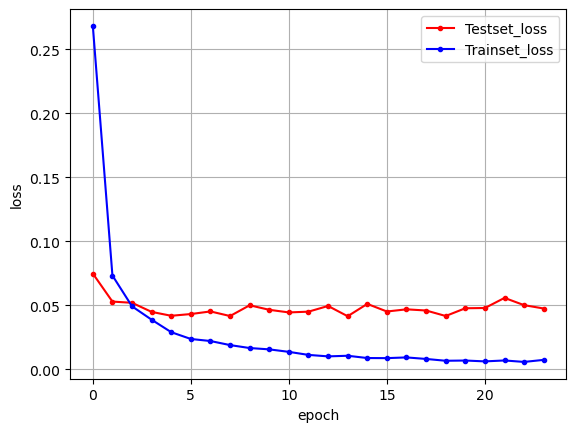

In [10]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 봅니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시해 보겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()